## Testing some python codes

In [1]:
import os
from os.path import join
import pandas as pd
import numpy as np
from behavior_selection import behavior_selection
from neural_matrix import neural_matrix
from neuro_behavior_options import neuro_behavior_options
from load_data import load_data
import pacmap


# figurePath = '/Users/paulmiddlebrooks/Projects/ridgeregress/docs/'
# bhvDataPath = '/Users/paulmiddlebrooks/Projects/neuro-behavior/data/processed_behavior/'
# nrnDataPath = '/Users/paulmiddlebrooks/Projects/neuro-behavior/data/raw_ephys/'
# saveDataPath = '/Users/paulmiddlebrooks/Projects/ridgeRegress/data/'
figurePath = 'E:/Projects/ridgeregress/docs/'
bhvDataPath = 'E:/Projects/neuro-behavior/data/processed_behavior/'
nrnDataPath = 'E:/Projects/neuro-behavior/data/raw_ephys/'
saveDataPath = 'E:/Projects/ridgeRegress/data/'


animal = 'ag25290'
sessionBhv = '112321_1'
sessionNrn = '112321'

if sessionBhv == '112321_1':
    sessionSave = '112321'



opts = neuro_behavior_options()

nrnDataPath = nrnDataPath + 'animal_' + animal + '/' + sessionNrn + '/recording1/'

bhvDataPath = join(bhvDataPath, 'animal_'+ animal)
bhvFileName = 'behavior_labels_' + animal + '_' + sessionBhv + '.csv'

opts['dataPath'] = bhvDataPath
opts['fileName'] = bhvFileName

# Behavior data

In [2]:
figurePath = join(figurePath, animal, sessionSave, 'figures', f"start {opts['collectStart']} for {opts['collectFor']}")

if not os.path.exists(figurePath):
    os.makedirs(figurePath)


dataBhv = load_data(opts, 'behavior')


In [ ]:
codes = np.unique(dataBhv.ID)
behaviors = []  # behaviors: a Python list containing the behavior names
for iBhv in range(len(codes)):
    # first_idx = np.where(dataBhv['bhvID'] == codes[iBhv])[0][0]
    firstIdx = np.where(dataBhv['ID'] == codes[iBhv])[0][0]
    behaviors.append(dataBhv['Name'].iloc[firstIdx])

opts['behaviors'] = behaviors
opts['bhvCodes'] = codes
opts['validCodes'] = np.array(codes)[np.array(codes) != -1]

# Select valid behaviors
valiBhv = behavior_selection(dataBhv, opts)
opts['validBhv'] = valiBhv
# all_valid = np.sum(np.array(valiBhv), axis=1)  # A list of all the valid behavior indices

rmv_bhv = np.zeros(len(behaviors), dtype=int)
for i in range(len(behaviors)):
    if np.sum(valiBhv[:,i]) < 20:
        rmv_bhv[i] = 1

analyzeBhv = np.array(behaviors)[rmv_bhv == 0]
analyzeCodes = np.array(codes)[rmv_bhv == 0]


# Neural data

In [4]:
# Load data
opts['dataPath'] = nrnDataPath
data = load_data(opts, 'neuron')
data["bhvDur"] = dataBhv.Dur



# Find neuron clusters (ids) in each brain region
# allGood = (data['ci'].group.values == 'good') & (data['ci'].KSLabel.values == 'good')
allGood = ((data['ci'].group.values == 'good') & (data['ci'].KSLabel.values == 'good')) | ((data['ci'].group.values == 'mua') & (data['ci'].KSLabel.values == 'mua'))

goodM23 = allGood & (data['ci'].area == 'M23')
goodM56 = allGood & (data['ci'].area == 'M56')
goodCC = allGood & (data['ci'].area == 'CC')
goodDS = allGood & (data['ci'].area == 'DS')
goodVS = allGood & (data['ci'].area == 'VS')

opts['useNeurons'] = np.where(goodM23 | goodM56 | goodDS | goodVS)[0]

a = [np.sum(goodM23), np.sum(goodM56), np.sum(goodCC), np.sum(goodDS), np.sum(goodVS)]
np.sum(a)

# Make or load neural matrix
opts['useNeurons'] = np.where(goodM23 | goodM56 | goodDS | goodVS)[0]

dataMat, idLabels, areaLabels, removedNeurons = neural_matrix(data, opts)

idM23 = np.where(np.array(areaLabels) == 'M23')[0]
idM56 = np.where(np.array(areaLabels) == 'M56')[0]
idDS = np.where(np.array(areaLabels) == 'DS')[0]
idVS = np.where(np.array(areaLabels) == 'VS')[0]

print(f'{len(idM23)} M23\n{len(idM56)} M56\n{len(idDS)} DS\n{len(idVS)} VS')





Keeping 225 of 499 neurons
20 M23
49 M56
96 DS
60 VS


In [10]:
#  Create a vector of behavior IDs for each frame of the dataMat
dataBhv['StartFrame'] = 1 + np.floor(dataBhv.StartTime / opts['frameSize'])
dataBhv['DurFrame'] = np.floor(dataBhv.Dur / opts['frameSize'])

bhvIDMat = np.zeros(dataMat.shape[0])
for i in range(dataBhv.shape[0]):
    iInd = np.arange(dataBhv.StartFrame[i] - 1, dataBhv.StartFrame[i] + dataBhv.DurFrame[i] - 1, 1).astype(int)
    if iInd.any():
        bhvIDMat[iInd] = dataBhv.ID[i].astype(int)


array([9., 9., 9., ..., 1., 1., 0.])

### Standard PSTHS to use for analyses (concatenated by behavior types, etc)
 - Create 3-D psth data matrix of stacked peri-event start time windows (time X neuron X bout)
- Make one of spike counts and one of zscored spike counts

In [11]:
z_time = np.arange(-3, opts['frameSize'] + 2, opts['frameSize'])  #
z_window = np.round(z_time[:-1] / opts['frameSize']).astype(int)
z_start_ind = np.where(z_window == 0)[0][0]
full_time = np.arange(-1, opts['frameSize'] + 1, opts['frameSize'])
full_window = np.round(full_time[:-1] / opts['frameSize']).astype(int)
full_start_ind = np.where(full_window == 0)[0][0]
peri_time = np.arange(-0.1, opts['frameSize'] + 0.1, opts['frameSize'])
peri_window = (peri_time[:-1] / opts['frameSize']).astype(int)

eventMat = [None] * len(analyzeCodes)
eventMatZ = [None] * len(analyzeCodes)
periMatZ = [None] * len(analyzeCodes)

for iBhv, code in enumerate(analyzeCodes):
    iValidBhv = opts['validBhv'][:, opts['bhvCodes'] == code].flatten()
    bhvStartFrames = 1 + np.floor(np.divide(dataBhv.loc[np.logical_and(dataBhv['ID'] == code, iValidBhv.astype(bool)), 'StartTime'].values, opts['frameSize'])).astype(int)
    bhvStartFrames = bhvStartFrames[np.logical_and(bhvStartFrames >= -z_window[0] + 1, bhvStartFrames <= dataMat.shape[0] - z_window[-1])]

    n_trial = len(bhvStartFrames)

    iDataMat = np.zeros((len(z_window), dataMat.shape[1], n_trial))
    for j, start_frame in enumerate(bhvStartFrames):
        iDataMat[:, :, j] = dataMat[start_frame + z_window, :]
    
    mean_psth = np.mean(iDataMat, axis=2)
    mean_window = np.mean(mean_psth, axis=0)
    std_window = np.std(mean_psth, axis=0)

    # iDataMatZ = (iDataMat - mean_window) / std_window
    iDataMatZ = np.divide(iDataMat - mean_window.reshape(1, mean_window.size, 1), std_window.reshape(1, std_window.size, 1))

    eventMat[iBhv] = iDataMat[z_start_ind + full_window, :, :]
    eventMatZ[iBhv] = iDataMatZ[z_start_ind + full_window, :, :]
    # periMatZ[iBhv] = np.transpose(np.mean(iDataMatZ[z_start_ind + peri_window, :, :], axis=1), (2, 1, 0))
 


# Pacmap


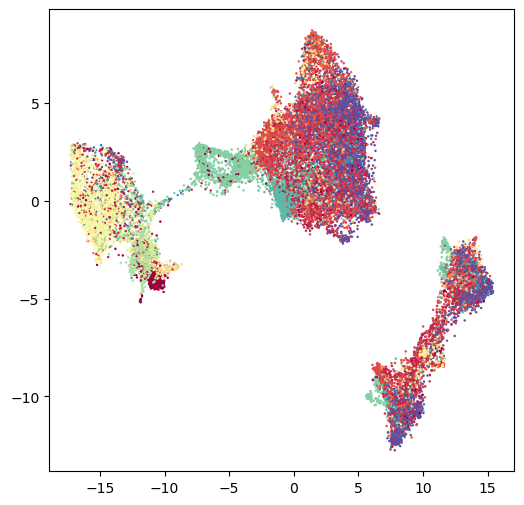

In [12]:
import pacmap
import numpy as np
import matplotlib.pyplot as plt


X = dataMat
# X = X.reshape(X.shape[0], -1)
y = bhvIDMat

# initializing the pacmap instance
# Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(X, init="pca")

# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=y, s=0.6)